```
Copyright 2022 IBM Corporation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Graph Features Extraction for Anti-Money Laudering

The Snap ML GraphFeaturePreprocessor is a scikit-learn compatible preprocessor that enables scalable and real-time feature extraction from graph-structured data. It provides utilities for creating and updating in-memory graphs as well as extracting new features from these graphs. 

The goal of this example is to show how to use the API of this preprocessor. As input, we will use a synthethic dataset in tabular format where each row represents a financial transaction. For each transaction a number of features are available: transaction ID, source account ID, destination accound ID and transaction timestamp. The main preprocessing steps that will be shown in this demo are briefly summarized below:

<div>
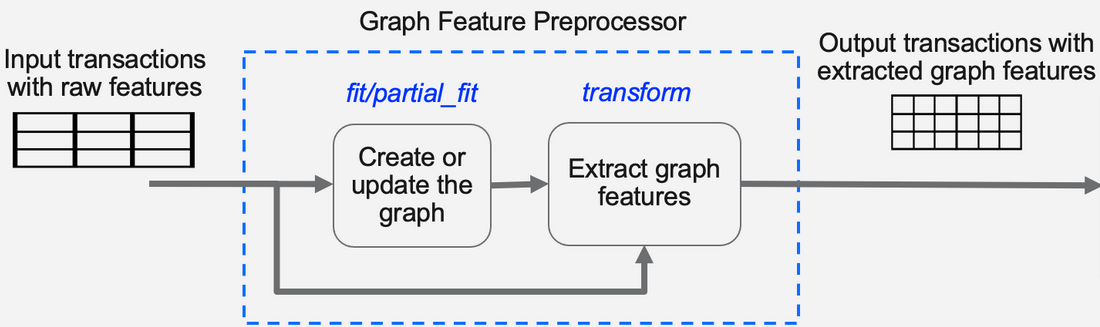
</div>


In [71]:
import numpy as np
from snapml import GraphFeaturePreprocessor
import time
import json
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None

In [72]:
# path to the file that contain financial transactions used to generate the initial graph
train_graph_path = "../datasets/graph-feature-preprocessor/aml_custom_train.txt"

# path to the file that contains financial transactions for which graph-based features will be computed
test_transactions_path = "../datasets/graph-feature-preprocessor/aml_custom_test.txt"

# the following data structure defines the feature extraction parameters
params = {
    "num_threads": 4,             # number of software threads to be used
    "time_window": 16,            # time window used if no pattern was specified
    
    "vertex_stats": True,         # produce vertex statistics
    "vertex_stats_cols": [3],     # produce vertex statistics using the selected input columns
    
    # features: 0:fan,1:deg,2:ratio,3:avg,4:sum,5:min,6:max,7:median,8:var,9:skew,10:kurtosis
    "vertex_stats_feats": [0, 1, 2, 3, 4, 8, 9, 10],  # fan,deg,ratio,avg,sum,var,skew,kurtosis
    
    # fan in/out parameters
    "fan": True,
    "fan_tw": 16,
    "fan_bins": [y+2 for y in range(2)],
    
    # in/out degree parameters
    "degree": True,
    "degree_tw": 16,
    "degree_bins": [y+2 for y in range(2)],
    
    # scatter gather parameters
    "scatter-gather": True,
    "scatter-gather_tw": 16,
    "scatter-gather_bins": [y+2 for y in range(2)],
    
    # temporal cycle parameters
    "temp-cycle": True,
    "temp-cycle_tw": 16,
    "temp-cycle_bins": [y+2 for y in range(2)],
    
    # length-constrained simple cycle parameters
    "lc-cycle": False,
    "lc-cycle_tw": 16,
    "lc-cycle_len": 8,
    "lc-cycle_bins": [y+2 for y in range(2)],
}

In [73]:
print("Creating a graph feature preprocessor ")
gp = GraphFeaturePreprocessor()

print("Setting the parameters of the graph feature preprocessor ")
gp.set_params(params)

print("Graph feature preprocessor parameters: ", json.dumps(gp.get_params(), indent=4))

Creating a graph feature preprocessor 
Setting the parameters of the graph feature preprocessor 
Graph feature preprocessor parameters:  {
    "num_threads": 4,
    "time_window": 16,
    "vertex_stats": true,
    "vertex_stats_cols": [
        3
    ],
    "vertex_stats_feats": [
        0,
        1,
        2,
        3,
        4,
        8,
        9,
        10
    ],
    "fan": true,
    "fan_tw": 16,
    "fan_bins": [
        2,
        3
    ],
    "degree": true,
    "degree_tw": 16,
    "degree_bins": [
        2,
        3
    ],
    "scatter-gather": true,
    "scatter-gather_tw": 16,
    "scatter-gather_bins": [
        2,
        3
    ],
    "temp-cycle": true,
    "temp-cycle_tw": 16,
    "temp-cycle_bins": [
        2,
        3
    ],
    "lc-cycle": false,
    "lc-cycle_tw": 16,
    "lc-cycle_len": 8,
    "lc-cycle_bins": [
        2,
        3
    ]
}


In [78]:
# helper function to inspect the newly generated graph-based features for a given transaction
def print_enriched_transaction(transaction, params):
    colnames = []
    
    # add raw features names
    colnames.append("transactionID")
    colnames.append("sourceAccountID")
    colnames.append("targetAccountID")
    colnames.append("timestamp")
    
    # add features names for the graph patterns
    for pattern in ['fan', 'degree', 'scatter-gather', 'temp-cycle', 'lc-cycle']:
        if pattern in params:
            if params[pattern]:
                bins = len(params[pattern +'_bins'])
                if pattern in ['fan', 'degree']:
                    for i in range(bins-1):
                        colnames.append(pattern+"_in_bins_"+str(params[pattern +'_bins'][i])+"-"+str(params[pattern +'_bins'][i+1]))
                    colnames.append(pattern+"_in_bins_"+str(params[pattern +'_bins'][i+1])+"-inf")
                    for i in range(bins-1):
                        colnames.append(pattern+"_out_bins_"+str(params[pattern +'_bins'][i])+"-"+str(params[pattern +'_bins'][i+1]))
                    colnames.append(pattern+"_out_bins_"+str(params[pattern +'_bins'][i+1])+"-inf")
                else:
                    for i in range(bins-1):
                        colnames.append(pattern+"_bins_"+str(params[pattern +'_bins'][i])+"-"+str(params[pattern +'_bins'][i+1]))
                    colnames.append(pattern+"_bins_"+str(params[pattern +'_bins'][i+1])+"-inf")

    current_colnames_len = len(colnames)
    
    # TODO: define and add the column names for the vertex statistics
    for i in range(transaction.shape[1]-current_colnames_len):
        colnames.append("xx")
    
    # add features names for the vertex statistics
    df = pd.DataFrame(transaction, columns=colnames)
    display(df)

In [79]:
print("Loading the train graph ")
X_train = np.loadtxt(train_graph_path, dtype=np.float64, delimiter=" ", comments="#", usecols=range(4))

df = pd.DataFrame(X_train, columns=['transactionID', 'sourceAccountID', 'targetAccountID', 'timestamp'])
display(df)

print("Creating the graph using the loaded transactions ")
gp.fit(X_train)


print("Loading the test transactions ")
X_test = np.loadtxt(test_transactions_path, dtype=np.float64, delimiter=" ", comments="#", usecols=range(4))

df = pd.DataFrame(X_test, columns=['transactionID', 'sourceAccountID', 'destinationAccountID', 'timestamp'])
display(df)

# user-defined parameter, transform can run on single transactions or on batches of transactions
batch_size = 1

print("Enriching the test transactions with new graph features ")

for i in range(X_test.shape[0]):
    new_transaction_raw_features = X_test[i : i + batch_size, :].astype("float64")
    new_transaction_enriched_features = gp.transform(new_transaction_raw_features)
    print_enriched_transaction(new_transaction_enriched_features, gp.get_params())

Loading the train graph 


,transactionID,sourceAccountID,targetAccountID,timestamp
0,0.0,0.0,1.0,0.0
1,1.0,1.0,2.0,1.0
2,2.0,2.0,3.0,2.0
3,3.0,1.0,3.0,3.0
4,4.0,3.0,1.0,4.0
5,5.0,3.0,0.0,5.0
6,6.0,0.0,2.0,6.0
7,7.0,2.0,0.0,7.0


Creating the graph using the loaded transactions 
Loading the test transactions 


,transactionID,sourceAccountID,destinationAccountID,timestamp
0,8.0,8.0,9.0,8.0
1,9.0,9.0,10.0,9.0
2,10.0,10.0,11.0,10.0
3,11.0,9.0,11.0,11.0
4,12.0,11.0,9.0,12.0
5,13.0,11.0,8.0,13.0
6,14.0,8.0,10.0,14.0
7,15.0,10.0,8.0,15.0


Enriching the test transactions with new graph features 


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,8.0,8.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,8.0,8.0,0.0,0.0,0.0


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,9.0,9.0,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,9.0,9.0,0.0,0.0,0.0,1.0,1.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,9.0,9.0,0.0,0.0,0.0


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,10.0,10.0,11.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,10.0,0.0,0.0,0.0,1.0,1.0,1.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,10.0,0.0,0.0,0.0


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,11.0,9.0,11.0,11.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,10.0,20.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,10.5,21.0,0.25,0.0,1.0


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,12.0,11.0,9.0,12.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,12.0,12.0,0.0,0.0,0.0,2.0,2.0,1.0,10.5,21.0,0.25,0.0,1.0,2.0,2.0,1.0,10.0,20.0,1.0,0.0,1.0,2.0,2.0,1.0,10.0,20.0,4.0,0.0,1.0


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,13.0,11.0,8.0,13.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,12.5,25.0,0.25,0.0,1.0,2.0,2.0,1.0,10.5,21.0,0.25,0.0,1.0,1.0,1.0,1.0,8.0,8.0,0.0,0.0,0.0,1.0,1.0,1.0,13.0,13.0,0.0,0.0,0.0


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,14.0,8.0,10.0,14.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,2.0,1.0,11.0,22.0,9.0,0.0,1.0,1.0,1.0,1.0,13.0,13.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,10.0,0.0,0.0,0.0,2.0,2.0,1.0,11.5,23.0,6.25,0.0,1.0


,transactionID,sourceAccountID,targetAccountID,timestamp,fan_in_bins_2-3,fan_in_bins_3-inf,fan_out_bins_2-3,fan_out_bins_3-inf,degree_in_bins_2-3,degree_in_bins_3-inf,degree_out_bins_2-3,degree_out_bins_3-inf,scatter-gather_bins_2-3,scatter-gather_bins_3-inf,temp-cycle_bins_2-3,temp-cycle_bins_3-inf,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx,xx
0,15.0,10.0,8.0,15.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,2.0,1.0,12.5,25.0,6.25,0.0,1.0,2.0,2.0,1.0,11.5,23.0,6.25,0.0,1.0,2.0,2.0,1.0,11.0,22.0,9.0,0.0,1.0,2.0,2.0,1.0,14.0,28.0,1.0,0.0,1.0
